# Homework 4
Do the programing part of Homework 4 in this notebook. 

### Task 1
You will need to run this code and understand it.


### Task 2
You will need to add your implementation to this code.


Done: 100 customers processed after time 0.65 hr
Procedure: B (one line for all servers)
Mean processing time: 1.70 min
Mean checkout time: 2.55 min
Median checkout time: 2.38 min
Standard deviation: 0.80 min


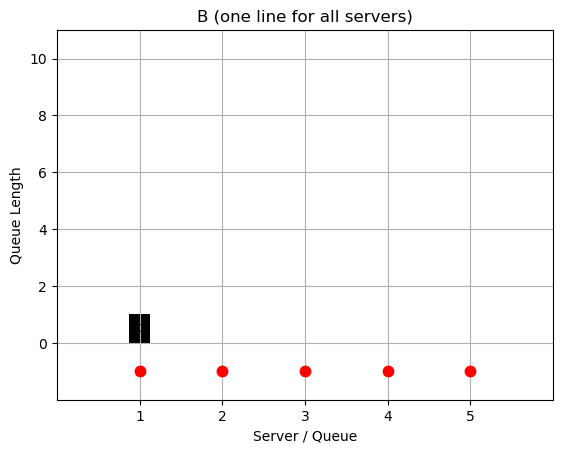

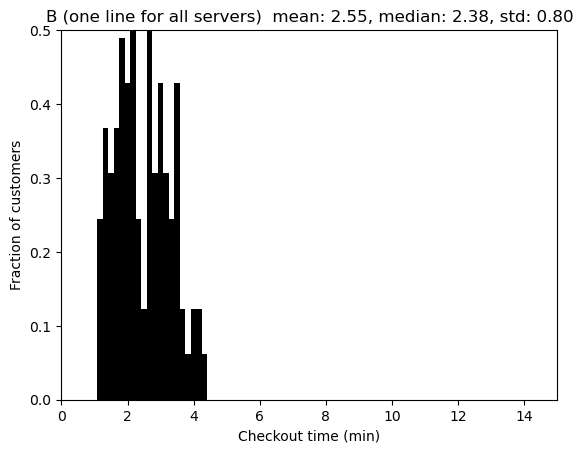

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Physical parameters
num_servers = 5   #            the number of cash registers at the checkout
delta = 0.5       # min        time spent paying, a constant for all customers 
alpha = 0.05      # min/item   time at server for each item
gamma = 2.5       # 1/min      rate of arrival of customers at the checkout area 


# Option to save an animation of the queues
# this will slow down the code, so don't do this with a large number of total customers
show_queues = False


# Distribution of items per customer, assumed to be negative binomial
mean_items = 24                     # the average number of items per customer
nbr = 4                             # the r parameter for the negative binomial distribution
nbp = nbr / (mean_items - 1 + nbr)  # the p parameter for the negative binomial distribution


# Check necessary stability condition
mean_processing_time = delta + mean_items * alpha
if mean_processing_time / num_servers > 1 / gamma:
    print("Warning: stability is not possible")


# Numerical parameters
total_customers = 10**4     # indirectly determines the duration of the simulation



### Setup the customers table
# The customers table stores all information about each customer, one row
# per customer. The six columns are: the time the customer arrived at the 
# checkout area, the number of items the customer has, the processing time 
# for that customer at the server, the number of the queue that the 
# customer is in, the position the customer in the queue, and the time that
# the customer departed the store
num_alloc = total_customers + 2    # number of customers to pre-allocate storage for, may need more
num_customer_cols = 6
customers = np.full((num_alloc, num_customer_cols), np.nan)

col_arrival_time = 0
col_number_of_items = 1
col_processing_time = 2
col_queue_number = 3
col_queue_position = 4
col_departure_time = 5


# Events
num_events = 1 + num_servers
event_customer_arrive = 0
event_customer_done = np.arange(1, num_servers + 1)


# Procedures
procedure_A = 1
procedure_B = 2
procedure = procedure_B  # PICK THE PROCEDURE HERE

if procedure == procedure_A:
    prod_str = 'A (line per server, join shortest)'
    num_queues = num_servers
elif procedure == procedure_B:
    prod_str = 'B (one line for all servers)'
    num_queues = 1
    queue_the_only_queue = 0


# Initialize
t = 0
num_customers = 0
next_customer_arrival = t + np.random.exponential(1 / gamma)  # alternative: next_t = t - 1/gamma*log(rand());
checkout_done = np.full(num_servers, np.inf)

if show_queues:
    fig, ax = plt.subplots()
    bars = ax.bar([], [], width=0.25, color='k')

    frames_data = []  # List to store animation frames


# Animation function to update the plot
def update_frame(frame_data):
    ax.cla()
    ax.set_xlabel('Server / Queue')
    ax.set_ylabel('Queue Length')
    ax.set_title(prod_str)
    ax.grid(True)

    queue_lengths, busy_servers, queue_customers_data = frame_data

    qn = np.arange(1, num_queues + 1)
    ax.bar(qn, queue_lengths, width=0.25, color='k')

    ax.plot(busy_servers + 1, np.zeros(len(busy_servers)) - 1, '.r', markersize=15)

    for queue_num in range(num_queues):
        queue_customers = queue_customers_data[queue_num]
        for pos, items in queue_customers:
            x_center = queue_num + 1
            y_center = queue_lengths[queue_num] - pos + 0.5
            ax.text(x_center, y_center, str(int(items)), ha='center', va='center', fontsize=8)

    ax.set_xlim([0, max(num_queues, num_servers) + 1])
    MQ = max(np.max(queue_lengths), 10)
    ax.set_ylim([-2, MQ + 1])

    ax.set_xticks(np.arange(1, max(num_queues, num_servers) + 1))
    ax.set_yticks(np.arange(0, MQ + 1, 2))



# Some comments for explanation:
# 1) an event is either a customer arrival (event=1) or a server is done (which server is one minus the event number)
# 2) events are processed and then the queues are updated
# 3) when an entry in checkout_done is Inf that means the server is available
# 4) the different procedures affect where a new customer is placed and how the queues are updated

# Simulation loop - jump from event to event
while num_customers < total_customers:

    # Determine which event and update the time
    event_times = np.full(num_events, np.nan)
    event_times[event_customer_arrive] = next_customer_arrival
    event_times[1:] = checkout_done
    t = np.min(event_times)
    event = np.argmin(event_times)

    # Process the event
    if event == event_customer_arrive:   # a new customer has arrived at the checkout area
        num_customers += 1
        if num_customers >= len(customers):
            # expand the customers table because it has run out of space
            customers = np.vstack((customers, np.full((num_alloc, num_customer_cols), np.nan)))
        
        customers[num_customers, col_arrival_time] = t   # record the arrival time of the customer
        N = 1 + np.random.negative_binomial(nbr, nbp)    # choose number of items by sampling the negative binomial distribution
        customers[num_customers, col_number_of_items] = N  # record the number of items of the customer
        customers[num_customers, col_processing_time] = delta + alpha * N  # record the processing time of the customer

        if procedure == procedure_A:
            valid_queue_numbers = customers[:num_customers, col_queue_number]
            valid_queue_numbers = valid_queue_numbers[~np.isnan(valid_queue_numbers) & (valid_queue_numbers >= 0)].astype(int)
            lengths = np.bincount(valid_queue_numbers, minlength=num_queues)

            # pick the queue
            # assign the new customer to a server queue with the fewest number of customers
            queue_no = np.argmin(lengths + (checkout_done != np.inf))   # count also the customer at server, if any
            customers[num_customers, col_queue_number] = queue_no

            # assign the customer to the queue
            customers[num_customers, col_queue_position] = lengths[queue_no] + 1
        elif procedure == procedure_B:

            # join the back of the queue
            num_in_queue = np.sum(customers[:num_customers, col_queue_number] == queue_the_only_queue)
            customers[num_customers, col_queue_number] = queue_the_only_queue
            customers[num_customers, col_queue_position] = num_in_queue + 1

        # sample the exponential distribution to get the next customer arrival time
        next_customer_arrival = t + np.random.exponential(1 / gamma)   # alternative: next_t = t - 1/gamma*log(rand());
    
    else: # a server finished
        server_num = event - 1
        checkout_done[server_num] = np.inf

    # Queue update logic
    if procedure == procedure_A:
        for server in range(num_servers):
            while checkout_done[server] == np.inf and np.any(customers[:num_customers, col_queue_number] == server):

                # a customer is in a queue and the corresponding server is available
                valid_customers = customers[:num_customers]
                next_customer = np.where((valid_customers[:, col_queue_number] == server) & 
                                         (valid_customers[:, col_queue_position] == 1))[0]

                # move the nextcustomer to the available server
                if next_customer.size == 0:
                    break
                next_customer = next_customer[0]
                customers[next_customer, col_queue_number] = -1
                customers[next_customer, col_queue_position] = np.nan
                time_done = t + customers[next_customer, col_processing_time]
                customers[next_customer, col_departure_time] = time_done
                checkout_done[server] = time_done

                # move the customers ahead in the line
                customers[(customers[:, col_queue_number] == server) & ~np.isnan(customers[:, col_queue_position]), col_queue_position] -= 1

    elif procedure == procedure_B:
        while np.any(checkout_done == np.inf) and np.any(customers[:num_customers, col_queue_number] == queue_the_only_queue):
            valid_customers = customers[:num_customers]
            server_open = np.where(checkout_done == np.inf)[0][0]
            next_customer = np.where((valid_customers[:, col_queue_number] == queue_the_only_queue) & 
                                     (valid_customers[:, col_queue_position] == 1))[0]
            
            # move the nextcustomer to the available server
            if next_customer.size == 0:
                break
            next_customer = next_customer[0]

            customers[next_customer, col_queue_number] = -1
            customers[next_customer, col_queue_position] = np.nan
            time_done = t + customers[next_customer, col_processing_time]
            customers[next_customer, col_departure_time] = time_done
            checkout_done[server_open] = time_done

            # move the customers, behind nextcustomer, ahead in the line
            customers[(customers[:, col_queue_number] == queue_the_only_queue) & 
                      (customers[:, col_queue_position] > 1), col_queue_position] -= 1

    if show_queues:
        valid_queue_numbers = customers[:num_customers, col_queue_number]
        valid_queue_numbers = valid_queue_numbers[~np.isnan(valid_queue_numbers) & (valid_queue_numbers >= 0)].astype(int)
        queue_lengths = np.bincount(valid_queue_numbers, minlength=num_queues)
        busy_servers = np.where(checkout_done != np.inf)[0]

        queue_customers_data = []
        for queue_num in range(num_queues):
            queue_customers = customers[:num_customers][customers[:num_customers, col_queue_number] == queue_num]
            positions = queue_customers[:, col_queue_position]
            items = queue_customers[:, col_number_of_items]
            valid_positions = positions[~np.isnan(positions)]
            valid_items = items[~np.isnan(positions)]
            queue_customers_data.append(list(zip(valid_positions, valid_items)))

        frames_data.append((queue_lengths, busy_servers, queue_customers_data))


if show_queues:
    ani = animation.FuncAnimation(fig, update_frame, frames=frames_data, interval=100, repeat=False)
    ani.save('grocery_animation.mp4', writer='ffmpeg', fps=10)


# Compute statistics on the checkout times
checkout_times = customers[~np.isnan(customers[:, col_departure_time]), col_departure_time] - customers[~np.isnan(customers[:, col_departure_time]), col_arrival_time]

mean_checkout_time = np.mean(checkout_times)
median_checkout_time = np.median(checkout_times)
std_checkout_time = np.std(checkout_times)

# Output
print(f"Done: {num_customers} customers processed after time {t / 60:.2f} hr")
print(f"Procedure: {prod_str}")
print(f"Mean processing time: {mean_processing_time:.2f} min")
print(f"Mean checkout time: {mean_checkout_time:.2f} min")
print(f"Median checkout time: {median_checkout_time:.2f} min")
print(f"Standard deviation: {std_checkout_time:.2f} min")

# Visualization - make the bar plot of the probability distribution
plt.figure()
bin_width = 1/6
bin_ranges = np.arange(0, 1.01 * np.max(checkout_times) + bin_width, bin_width)
counts, _ = np.histogram(checkout_times, bins=bin_ranges, density=True)
plt.bar(bin_ranges[:-1], counts, width=bin_width, color='k')
plt.xlabel('Checkout time (min)')
plt.ylabel('Fraction of customers')
plt.title(f'{prod_str}  mean: {mean_checkout_time:.2f}, median: {median_checkout_time:.2f}, std: {std_checkout_time:.2f}')
plt.ylim([0,0.5])   # Remove this if it's cropping the graph above
plt.xlim([0,15])
# plt.savefig('grocery_sim.png')
plt.show()